In [ ]:
# Go to cobolt installation
%cd /home/user/cobolt

from cobolt.utils import SingleData, MultiomicDataset
from cobolt.model import Cobolt
import os
import numpy as np
import scipy
import pandas as pd
import scib
import anndata
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
dirs = { "1_0.1": [], "3_0.1": [], "5_0.1": [], "1_0.5": [], "3_0.5": [], "5_0.5": [] }

for tree in [1, 3, 5]:
    for ncell in [500, 800]:
        for ngene in [110, 200, 500]:
            for sigma in [0.1, 0.5]:
                for seed in [1, 2, 3, 4]:
                    root_dir = f"unif/tree{tree}_{ncell}_cells{ngene}_genes_sigma{sigma}_{seed}/integ/"
                    dirs[f"{tree}_{sigma}"].append(root_dir)

In [68]:
def run_cobolt(path, lr, lq):
    meta = pd.read_csv(os.path.join(path, "meta.csv"), sep=",", index_col=0)
    ncells = meta.shape[0]
    meta.index = map(lambda x: x+1, range(ncells))
    
    pop_list = meta.loc[:,"pop"].to_numpy()
    pop_map = {}
    for i, j in enumerate(np.unique(pop_list)):
        pop_map[j] = i
    
    def get_ds(file):
        ds_type = "ChromAccess" if "atac" in file else "GeneExpr"
        count_obs = pd.read_csv(os.path.join(path, file + ".csv"), sep=",", index_col=0)
        feature = count_obs.columns.values.astype('str')
        barcode = count_obs.index.values.astype('str')

        count_obs_b1 = count_obs[meta.batch == 1]
        count_b1 = scipy.sparse.csr_matrix(count_obs_b1.values)
        res_b1 = SingleData(ds_type, "Batch1", feature, count_b1, barcode[meta.batch == 1])
        res_b1.filter_features(upper_quantile=0.99, lower_quantile=lq)

        count_obs_b2 = count_obs[meta.batch == 2]
        count_b2 = scipy.sparse.csr_matrix(count_obs_b2.values)
        res_b2 = SingleData(ds_type, "Batch2", feature, count_b2, barcode[meta.batch == 2])
        res_b2.filter_features(upper_quantile=0.99, lower_quantile=lq)
        
        count_obs_b3 = count_obs[meta.batch == 3]
        count_b3 = scipy.sparse.csr_matrix(count_obs_b3.values)
        res_b3 = SingleData(ds_type, "Batch3", feature, count_b3, barcode[meta.batch == 3])
        res_b3.filter_features(upper_quantile=0.99, lower_quantile=lq)

        return res_b1, res_b2, res_b3

    ds_mrna_b1, ds_mrna_b2, ds_mrna_b3 = get_ds("counts_obs")
    ds_atac_b1, ds_atac_b2, ds_atac_b3 = get_ds("atac_obs")
    
    if len(ds_mrna_b1.barcode) == 1025:
        raise RuntimeError('cell num is 1025')
    
    multi_dt = MultiomicDataset.from_singledata(
        ds_atac_b1, ds_mrna_b1, ds_atac_b2, ds_mrna_b3)
    print(multi_dt)
    
    model = Cobolt(dataset=multi_dt, lr=lr, n_latent=10)
    model.train(num_epochs=20)

    model.calc_all_latent()
    
    return model, pop_map, pop_list

In [ ]:
for tree, root_dirs in dirs.items():
    for root_dir in root_dirs:
        path = root_dir
        print(path)

        out_path = os.path.join(root_dir, "out_cobolt")
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        h5ad_path = os.path.join(out_path, "res.h5ad")

        try:
            model, pop_map, pop_list = run_cobolt(path, 0.005, 0.5)
        except RuntimeError:
            continue
        except ValueError as err:
            print(str(err))
            if 'per channel' in str(err).lower():
                continue
            if 'diverge' in str(err).lower():
                print("retry 0.001")
                model, pop_map, pop_list = run_cobolt(path, 0.001, 0.5)
            else:
                model, pop_map, pop_list = run_cobolt(path, 0.005, 0.05)
        latent, barcode = model.get_all_latent()
        cell_ids = np.array([
            int(b.split('~')[-1]) - 1
            for b in barcode
        ])
        anno = np.array([
            pop_map[pop_list[i]]
            for i in cell_ids
        ])

#         model.clustering(algo="leiden", resolution=1)
#         predicted = model.cluster_model.cluster["leiden_1.000"]

#         pred_labels = np.unique(predicted)
#         anno_labels = np.unique(anno)

#         cls_map = {}
#         cls_mat = np.empty((0, 3))
#         for a in pred_labels:
#             for b in anno_labels:
#                 xa = (predicted == a)
#                 xb = (anno == b)
#                 ratio = (xa & xb).sum() / (xa | xb).sum()
#                 cls_mat = np.vstack([cls_mat, [a, b, ratio]])

#         cls_mat = cls_mat[np.flip(cls_mat[:, 2].argsort())]
#         for i in range(cls_mat.shape[0]):
#             a = int(cls_mat[i, 0])
#             b = int(cls_mat[i, 1])
#             if a not in cls_map:
#                 cls_map[a] = b

#         predicted_mapped = predicted.copy()
#         for a, b in cls_map.items():
#             predicted_mapped[predicted == a] = b
            
        meta_orig = pd.read_csv(os.path.join(root_dir, "meta.csv"), index_col=0)
        counts_orig = pd.read_csv(os.path.join(root_dir, "counts_s.csv"), index_col=0)
        counts_orig.index = list(range(counts_orig.shape[0]))
        adata = anndata.AnnData(X=counts_orig.loc[pd.Index(cell_ids)], dtype=counts_orig.values.dtype)

        adata.obs["pop"] = anno.astype(str)
        adata.obs["celltype"] = adata.obs["pop"]
#         adata.obs["predicted.l1"] = predicted_mapped.astype(str)
        adata.obs["batch"] = [b[5] for b in barcode]
        adata.obs["batch"] = adata.obs["batch"].astype("category")
        adata.obs["celltype"] = adata.obs["celltype"].astype("category")
        adata.layers["counts"] = adata.X
        adata.obsm["X_emb"] = latent

        adata.write(h5ad_path)

In [ ]:
for tree, root_dirs in dirs.items():
    ari_list = []
    nmi_list = []
    gc_list = []
    asw_label_list = []
    asw_batch_list = []
    
    out_path_all = "unif/"
    
    for root_dir in root_dirs:
        path = root_dir
        print(path)
                
        out_path = os.path.join(root_dir, "out_cobolt")
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        h5ad_path = os.path.join(out_path, "res.h5ad")
        if not os.path.exists(h5ad_path):
            continue

        adata = anndata.read(h5ad_path)
        if "X_emb" not in adata.obsm:
            continue
            
        adata_int = adata.copy()

        scib.pp.reduce_data(
            adata, pca=True, n_top_genes=None, neighbors=True, umap=False, pca_comps = 5
        )
        scib.pp.reduce_data(
            adata_int, batch_key="batch", pca=True, n_top_genes=None, neighbors=True, umap=False, pca_comps = 5, use_rep="X_emb"
        )

        me = scib.me.metrics(adata, adata_int, embed="X_emb", batch_key="batch", label_key="celltype", ari_=True, nmi_=True, graph_conn_=True,silhouette_=True)
        ari_list.append(me.loc["ARI_cluster/label", 0])
        nmi_list.append(me.loc["NMI_cluster/label", 0])
        gc_list.append(me.loc["graph_conn", 0])
        asw_label_list.append(me.loc["ASW_label", 0])
        asw_batch_list.append(me.loc["ASW_label/batch", 0])
                
    pd.DataFrame.from_dict({
        "ari": ari_list,
        "nmi": nmi_list,
        "gc": gc_list,
        "asw_label": asw_label_list,
        "asw_batch": asw_batch_list
    }).to_csv(os.path.join(out_path_all, f"cobolt3_tree{tree}.csv"))

## Visualize individual integration result

In [84]:
def visualize(data_path, tool="cobolt"):
    print(data_path)
    
    if tool == "cobolt":
        adata = anndata.read(os.path.join(data_path, f"out_{tool}", "res.h5ad"))
    else:
        raise "cobolt only"
        
    ump = TSNE(n_components=2).fit_transform(adata.obsm["X_emb"])
        
    df = pd.DataFrame.from_dict({
        "x": ump[:, 0],
        "y": ump[:, 1],
        "celltype": adata.obs["celltype"],
        "batch": adata.obs["batch"]
    }).sample(frac=1)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.set(style="darkgrid")
    sns.scatterplot(x="x", y="y", hue="celltype", data=df, size=1, ax=axs[0])
    sns.scatterplot(x="x", y="y", hue="batch", data=df, size=1, ax=axs[1])
    axs[0].set_title("Cell Type")
    axs[1].set_title("Batch")

    plt.show()

/project/hli691/scm_sim/unif/tree5_800_cells500_genes_sigma0.1_2/integ2/


/nethome/hli691/.miniconda3/envs/cobolt/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nethome/hli691/.miniconda3/envs/cobolt/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/nethome/hli691/.miniconda3/envs/cobolt/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/nethome/hli691/.miniconda3/envs/cobolt/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


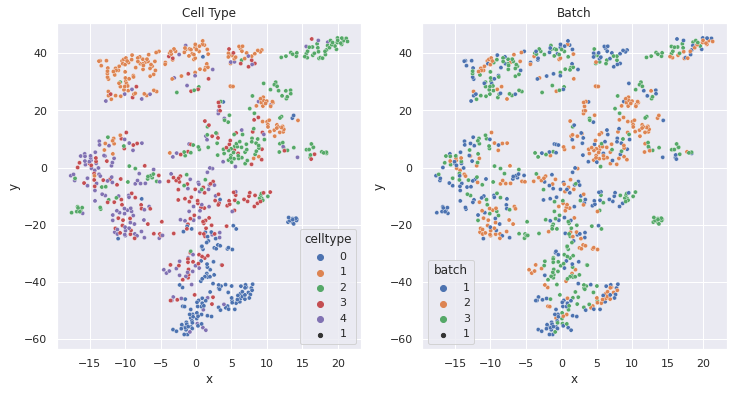

In [90]:
visualize(dirs["5_0.1"][21])